- Handling modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from scipy.stats import kruskal
from typing import Tuple
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler

- Auxiliar functions

In [3]:
def classify_iga_level(avg):
    if avg > 100:
        return "High sIgA"
    elif avg < 30:
        return "Low sIgA"
    else:
        return "Moderate sIgA"

In [4]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """
    from scipy.stats import mannwhitneyu

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "Negligible"
    elif abs_rbc < 0.3:
        interpretation = "Small"
    elif abs_rbc < 0.5:
        interpretation = "Medium"
    else:
        interpretation = "Large"

    return rbc, interpretation

In [5]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "Negligible"
    elif abs_delta < 0.33:
        interpretation = "Small"
    elif abs_delta < 0.474:
        interpretation = "Medium"
    else:
        interpretation = "Large"
    return delta, interpretation

-Loading data

In [6]:
df_data = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
df_data.head(5)

,ID,Gender,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,10,10.0,16.0,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,8,9.0,NaN,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


In [7]:
df_data.columns

Index(['ID', 'Gender', 'age_baby_1', 'age_baby_2', 'age_baby_5',
       'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment'],
      dtype='object')

In [8]:
df_data["Attachment"].value_counts()

Attachment
Secure      21
Insecure    14
Name: count, dtype: int64

- Data visualization

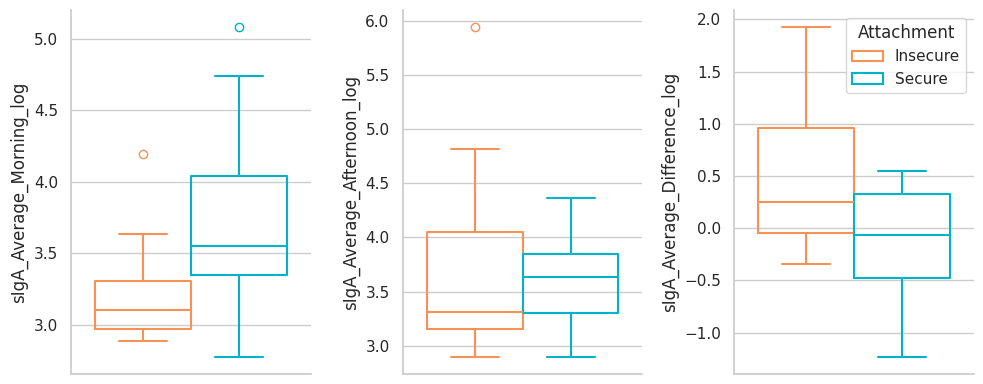

In [9]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Morning_log", 
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Afternoon_log", 
    hue="Attachment", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Difference_log", 
    hue="Attachment", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

In [26]:
data_figure_A = df_data[["Attachment", "sIgA_Average_Morning_log", "sIgA_Average_Afternoon_log", "sIgA_Average_Difference_log"]]
data_figure_A.to_csv("../data_for_figures/data_figure_A.csv", index=False)

- U-test and Kruskal comparison

In [10]:
iga_vars = ["sIgA_Average_Morning_log", "sIgA_Average_Afternoon_log", 
            "sIgA_Average_Difference_log"]

In [11]:
attachment_results = []
for var in iga_vars:
    secure_vals = df_data[df_data["Attachment"] == "Secure"][var]
    insecure_vals = df_data[df_data["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_results.append(statistic_result)

attachment_results = pd.DataFrame(attachment_results)
attachment_results["reject"] = attachment_results["p-value"]<=0.05
attachment_results

,variable,U statistic,p-value,reject
0,sIgA_Average_Morning_log,222.0,0.012123,True
1,sIgA_Average_Afternoon_log,164.0,0.578495,False
2,sIgA_Average_Difference_log,84.0,0.035336,True


- Cliffs estimation

In [12]:
attachment_cliffs = []
for var in iga_vars:
    secure = df_data[df_data["Attachment"] == "Secure"][var]
    insecure = df_data[df_data["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(insecure, secure)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,sIgA_Average_Morning_log,-0.510204,Large
1,sIgA_Average_Afternoon_log,-0.115646,Negligible
2,sIgA_Average_Difference_log,0.428571,Medium


- RBC estimation 

In [13]:
rbc_attachment = []
for var in iga_vars:
    secure = df_data[df_data["Attachment"] == "Secure"][var]
    insecure = df_data[df_data["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure, insecure)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,sIgA_Average_Morning_log,-0.510204,Large
1,sIgA_Average_Afternoon_log,-0.115646,Small
2,sIgA_Average_Difference_log,0.428571,Medium


- Merge comparisons

In [14]:
attachment_results.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,sIgA_Average_Morning_log,222.0,0.012123,True,-0.510204,Large,-0.510204,Large
1,sIgA_Average_Afternoon_log,164.0,0.578495,False,-0.115646,Negligible,-0.115646,Small
2,sIgA_Average_Difference_log,84.0,0.035336,True,0.428571,Medium,0.428571,Medium


### Additional analysis (1): PCA visualization and scatter plots

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [16]:
df_data.columns

Index(['ID', 'Gender', 'age_baby_1', 'age_baby_2', 'age_baby_5',
       'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment'],
      dtype='object')

In [17]:
df_for_reductions = df_data[iga_vars]
df_for_reductions.head()

,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log
0,3.077296,3.338237,0.260941
1,3.348951,3.687484,0.338533
2,5.084039,3.847334,-1.236705
3,3.179553,3.581917,0.402364
4,4.196295,5.947291,1.750996


In [18]:
pca_instance = PCA()
pca_instance.fit(X=df_for_reductions.values)
header = [f"p_{i+1}" for i in range(pca_instance.n_components_)]
data_transformed = pd.DataFrame(
    data=pca_instance.transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
print(pca_instance.n_components_)
print(pca_instance.explained_variance_ratio_)
data_transformed.head(5)

3
[5.72306460e-01 4.27693540e-01 8.70933491e-16]


,p_1,p_2,p_3
0,-0.027119,-0.527978,-2.314950e-15
1,0.207381,-0.144833,-5.368271e-16
2,-1.172084,1.756359,6.282201e-15
3,0.217066,-0.354166,-1.347384e-15
4,2.565062,1.358868,4.839574e-15


In [19]:
data_transformed = pd.concat([data_transformed, df_data], axis=1)
data_transformed.head(5)

,p_1,p_2,p_3,ID,Gender,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,-0.027119,-0.527978,-2.314950e-15,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,0.207381,-0.144833,-5.368271e-16,4,Male,10,10.0,16.0,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,-1.172084,1.756359,6.282201e-15,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,0.217066,-0.354166,-1.347384e-15,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,2.565062,1.358868,4.839574e-15,11,Male,8,9.0,NaN,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


In [20]:
tsne_instance = TSNE(n_components=2, perplexity=3)
header = ["p_1", "p_2"]
tsne_data_transformed = pd.DataFrame(
    data=tsne_instance.fit_transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
tsne_data_transformed.head(5)

,p_1,p_2
0,92.436333,56.192581
1,-40.284813,31.916088
2,-48.019646,-81.365303
3,-37.708855,42.249630
4,-38.593510,113.995880


In [21]:
tsne_data_transformed = pd.concat([tsne_data_transformed, df_data], axis=1)
tsne_data_transformed.head(5)

,p_1,p_2,ID,Gender,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,92.436333,56.192581,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,-40.284813,31.916088,4,Male,10,10.0,16.0,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,-48.019646,-81.365303,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,-37.708855,42.249630,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,-38.593510,113.995880,11,Male,8,9.0,NaN,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


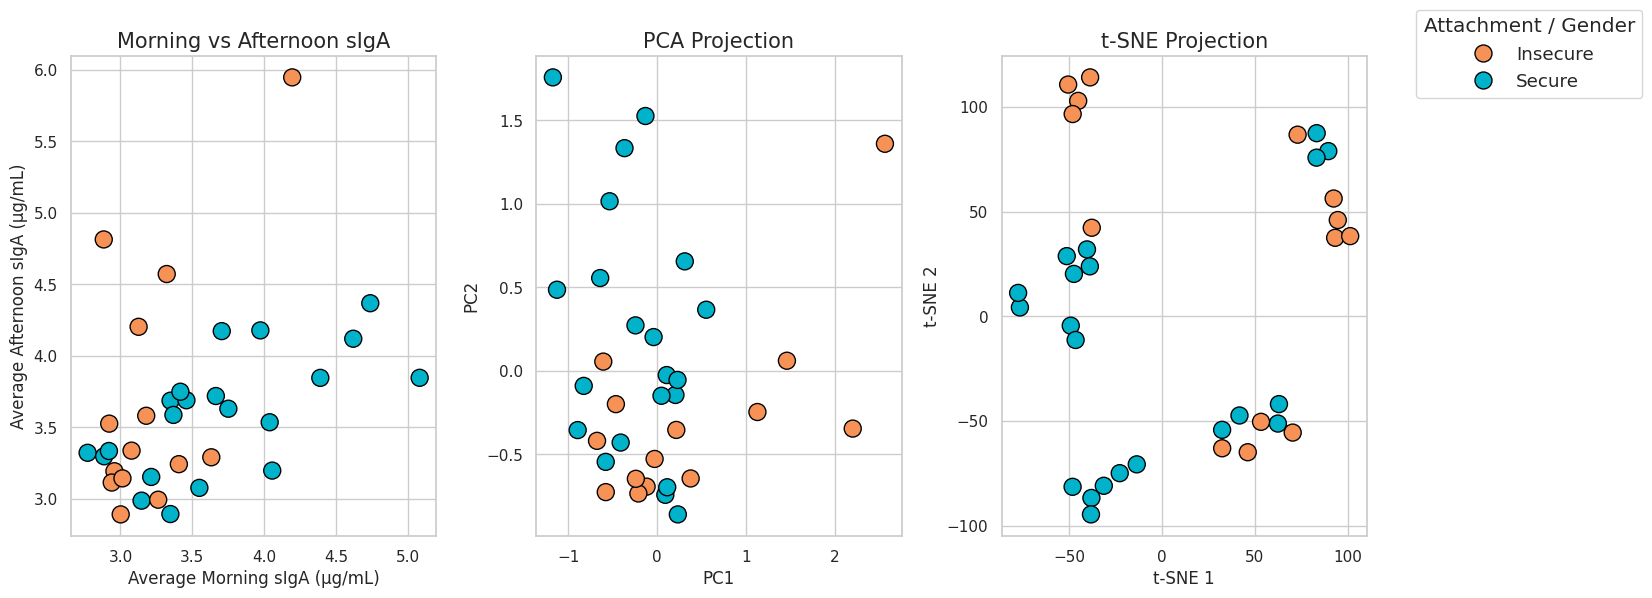

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=False)
sns.set(style="whitegrid", font_scale=1.2)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

# Gráfico 1: Promedio IgA Mañana vs Tarde
sns.scatterplot(
    ax=axes[0],
    data=df_data,
    x="sIgA_Average_Morning_log",
    y="sIgA_Average_Afternoon_log",
    hue="Attachment",
    palette=palette,
    s=150,
    edgecolor="black",
)

axes[0].set_title("Morning vs Afternoon sIgA", fontsize=15)
axes[0].set_xlabel("Average Morning sIgA (µg/mL)")
axes[0].set_ylabel("Average Afternoon sIgA (µg/mL)")

# Gráfico 2: Proyección PCA
sns.scatterplot(
    ax=axes[1],
    data=data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    palette=palette,
    s=150,
    edgecolor="black"
)

axes[1].set_title("PCA Projection", fontsize=15)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# Gráfico 3: Proyección t-SNE
sns.scatterplot(
    ax=axes[2],
    data=tsne_data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    palette=palette,
    s=150,
    edgecolor="black"
)
axes[2].set_title("t-SNE Projection", fontsize=15)
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title="Attachment / Gender", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

for ax in axes:
    ax.get_legend().remove()

plt.tight_layout()

In [28]:
data_figure_B = tsne_data_transformed[["Attachment", "p_1", "p_2"]]
data_figure_B.to_csv("../data_for_figures/data_figure_B.csv", index=False)

In [23]:
df_data.to_csv("../results_process/results_analysis_IgA_log_data.csv", index=False)